In [2]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/kaggle-nlp-disaster/* .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd

def load_dataset(training=True):
  df = pd.read_csv(f'{"train" if training else "test"}.csv')
  x = df.pop('text').to_list()

  if training:
    y = df.pop('target').to_list()
    return x, y
  else:
    id = df.pop('id').to_list()
    return id, x

In [9]:
from sklearn.model_selection import train_test_split

x_train, y_train = load_dataset(True)
submit_id, x_submit = load_dataset(False)

x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.05, random_state=42
)

In [18]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length,\
                                padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,\
                               padding=padding_type, truncating=trunc_type)

submission_sequences = tokenizer.texts_to_sequences(x_submit)
submission_padded = pad_sequences(submission_sequences, maxlen=max_length,\
                                  padding=padding_type, truncating=trunc_type)

training_labels = np.array(y_train)
testing_labels = np.array(y_test)

In [15]:
import tensorflow as tf

# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 24

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
optimizer = tf.keras.optimizers.Adam(1e-4)
model_lstm.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 24)                1560      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 174,129
Trainable params: 174,129
Non-trainable params: 0
_________________________________________________________________


In [16]:
NUM_EPOCHS = 10

# Train the model
history_lstm = model_lstm.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels))

Epoch 1/10
226/226 [==============================] - 10s 37ms/step - loss: 0.6846 - accuracy: 0.5690 - val_loss: 0.6821 - val_accuracy: 0.5486
Epoch 2/10
226/226 [==============================] - 6s 28ms/step - loss: 0.6577 - accuracy: 0.5785 - val_loss: 0.6425 - val_accuracy: 0.5958
Epoch 3/10
226/226 [==============================] - 6s 28ms/step - loss: 0.5952 - accuracy: 0.7168 - val_loss: 0.5927 - val_accuracy: 0.7218
Epoch 4/10
226/226 [==============================] - 6s 28ms/step - loss: 0.4963 - accuracy: 0.7865 - val_loss: 0.5324 - val_accuracy: 0.7585
Epoch 5/10
226/226 [==============================] - 6s 29ms/step - loss: 0.4106 - accuracy: 0.8269 - val_loss: 0.4926 - val_accuracy: 0.7795
Epoch 6/10
226/226 [==============================] - 6s 28ms/step - loss: 0.3559 - accuracy: 0.8567 - val_loss: 0.4938 - val_accuracy: 0.7743
Epoch 7/10
226/226 [==============================] - 6s 28ms/step - loss: 0.3170 - accuracy: 0.8721 - val_loss: 0.4990 - val_accuracy: 0.779

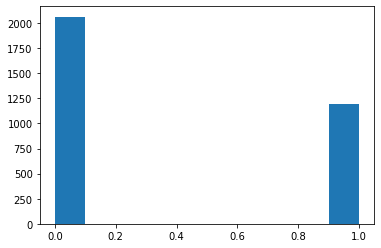

In [20]:
predict_y = model_lstm.predict_on_batch(submission_padded)
predict_y = predict_y > 0.5
predict_y = 1 * predict_y
predict_y = predict_y.squeeze(axis=-1)

plt.hist(predict_y)
plt.show()

pd.DataFrame({
    'id': submit_id,
    'target': predict_y,
}).to_csv('submission.csv', index=False)